In [23]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
import time
%matplotlib inline

%run ../sim_utilities.py

ERROR:root:File `'../sim_utilities.py'` not found.


Diversity_preserving_bandits.ipynb  kl_ucbs.pdf
Untitled.ipynb                      neurips_range_figures.ipynb
cachedir/                           range_adaptation.ipynb
fair_bandits.ipynb                  simplex_drawings.ipynb
fair_bandits_archive.ipynb


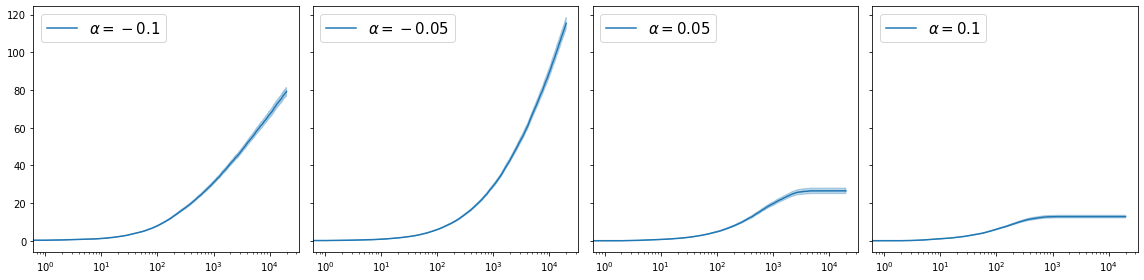

In [68]:
#%run ../sim_utilities.py
data_dict = load_data_dict('../data_saves/diversity/log_or_bounded_regret.pkl')
plot_and_save(data_dict, save_data=False, skip_algs=[], log_scale=True, clean=False)

plt.tight_layout()
plt.savefig('log_v_bounded_results.pdf')

#print('worst possible perf : ',str(T*delta_max))

In [67]:
alphas = [-0.1, -0.05, 0, +0.05, +0.1]

def plot_and_save(
    data_dict,
    save_figure=False,
    skip_algs=[],
    log_scale=True,
    show_vars=True,
    clean=False,
    **kwargs,
):
    """ Tailored to the range adaptation experiments """
    colors = plt.get_cmap("tab10").colors
    T = data_dict["T"]
    if "t_slice" in kwargs:
        t_slice = kwargs["t_slice"]
    else:
        t_slice = range(T)
    nplots = len(data_dict["band_list"]) -1
    fig, axes = plt.subplots(nrows=1, ncols=nplots, figsize=(16, 4), sharey="all")
    for i, _ in enumerate(data_dict["band_list"]):
        if nplots >= 2:  # axes[i] does not work when there is only 1 subplot
            if i > 2:
                ax = axes[i-1]
            else:
                ax = axes[i]
        else:
            ax = axes
        if i==2:
            continue
        for j, alg in enumerate(data_dict["alg_list"]):
            if j in skip_algs or not (data_dict["ended"][i][j]):
                continue
            mean_reg, var_reg = data_dict["results"][i][j]
            if "rescale" in kwargs.keys():
                if kwargs["rescale"]:
                    mean_reg = np.array(mean_reg) / data_dict["scales"][i]
                    var_reg = np.array(var_reg) / np.square(data_dict["scales"][i])
            if log_scale:
                ax.set_xscale("log")  # , nonposx='clip')
            if clean:
                alg_label = alg.label
            else:
                alg_label = r'$\alpha = {}$'.format(alphas[i])
            ax.plot(
                t_slice, mean_reg[t_slice], label=alg_label, color=colors[j],
            )
            if show_vars:
                sig = np.sqrt(var_reg[t_slice] / data_dict["N_tests"][i])
                ax.fill_between(
                    t_slice,
                    mean_reg[t_slice] + 2 * sig,
                    mean_reg[t_slice] - 2 * sig,
                    alpha=0.3,
                    color=colors[j],
                )
        
        ax.legend(loc=2, prop={'size': 15})
        

    if save_figure:
        plt.tight_layout()
        # save_data_dict(data_dict)
        path = uniquify(data_dict["short_name"] + ".pdf")
        plt.savefig(path, format="pdf")
        
        
        


# Sphere Constraints 
 - conjecture : logarithmic regret ? 
 - careful : does not work when the circle is larger than the simplex !!!

In [2]:
np.random.seed(4)

K = 10

mus = np.random.rand(K)
noise='bernoulli'

#r = 1/(2*K)
r = np.sqrt(1 + 1/(K-1))/K #maximal radius included in the simplex
r2 = (np.sqrt(1 + 1/(K-1))/K)*0.9
C = SphereConstraints(K, r)

band_list = [FairBand(K, mus, C, noise=noise),
            ]

N_tests = [5 for _ in band_list]


delta_max = [band.C.argmax_dot(mus).fun -(- band.C.argmax_dot(-mus).fun) for band in band_list]
print(delta_max)

[0.21947253070681694]


Div-UCB  took  2.370476007461548  total, i.e.,  0.47409520149230955  per run
FTL  took  2.3208460807800293  total, i.e.,  0.46416921615600587  per run


(<Figure size 1152x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x10df745f8>)

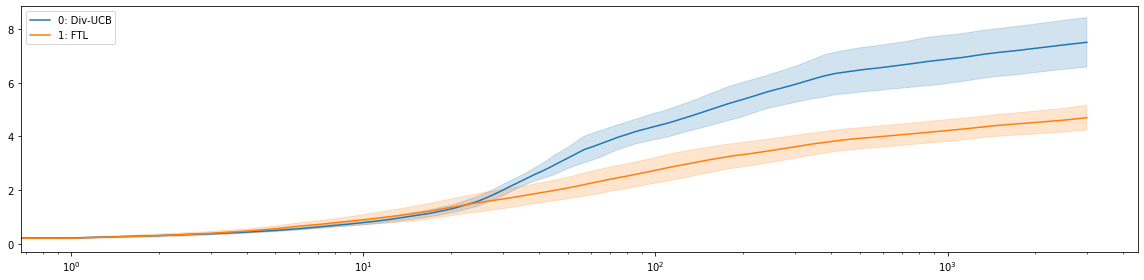

In [10]:
T = 3000

eps = 1.
alg_list = [#FairUCB(K, C, label='Div-kl-UCB', noise="bernoulli"),
            FairUCB(K, C, label='Div-UCB', noise="gaussian"),
            #L1OFUL(K, C, label="L1OFUL", delta=1/T),
            #FairEpsGreedy(K, C, label=r'$\epsilon$-greedy, $\epsilon =$'+str(eps), epsilon=eps), 
            FairEpsGreedy(K, C, label="FTL", epsilon=0)
           ]


skips = []
data_dict={
    'name':'Diversity-preserving bandits with a spherical probability set',
    'short_name':'fair',
    'T':T,
    'N_tests':N_tests,
    'band_list':band_list,
    'alg_list':alg_list,
    'results':None,
    'seed':0,
    'folder':'../figures/testing/',
}


launch(data_dict, fair_reg=True, checkpoints=False)


plot_and_save(data_dict,
                save_figure=False,
                skip_algs=skips,
                log_scale=True,
                show_vars=True,
                )


%run ../sim_utilities.py
plot_and_save(data_dict, skip_algs=[],  save_data=False)

print('worst possible perf : ',str(T * np.array(delta_max)))

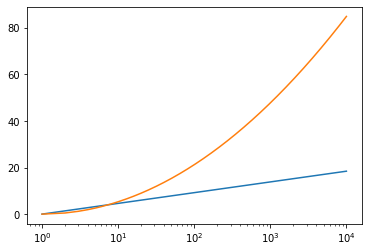

In [84]:
xs = np.arange(1, 10000)
plt.xscale('log')
plt.plot(xs, 2*np.log(xs))
plt.plot(xs, np.power(np.log(xs), 2))
#plt.plot(xs, 2*np.sqrt(xs))
#plt.plot(xs, xs)

# Uniform constraints : lower vs. upper bounds on each action

In [ ]:
np.random.seed(1919)

K = 3
mus = np.sort(np.random.rand(K))
noise='gaussian'

up_const = True
eps = 1/K**2
if up_const:## if us > (1/(K-1) then log regret)
    us = [1/(K-1) for _ in  range(K)]
    constraints_list = [(0, us[i], np.array([1*(j==i) for j in range(K)])) for i in range(K)]
else:
    ls = [1/K - eps for _ in range(K)]
    constraints_list = [(ls[i], 1, np.array([1*(j==i) for j in range(K)])) for i in range(K)]
C = PolytopeConstraints(K, constraints_list)

band_list = [FairBand(K, mus, C, noise=noise)]

min_reward = C.argmax_dot(-mus)
max_reward = C.argmax_dot(mus)
print(max_reward)
delta_max =  max_reward.fun - (- min_reward.fun)
#print("Un point qui vérifie les contraintes : ", C.feasible)
print("Ecart maximum pour ce problème : ", delta_max)

In [ ]:
T = 3000

eps = 1.
alg_list = [FairUCB(K, C,label='FairUCB'),
            #L1OFUL(K, C, label='OFUL', delta=1/T)
           ]

data_dict={
        'name':'Uniform lower bounds or upper bounds on each action',
        'short_name':'unif_bounds',
        'T':T,
        'Ntest':Ntest,
        'band_list':band_list,
        'alg_list':alg_list,
        'results':None,   
    }

launch(data_dict)

In [ ]:
%run sim_utilities.py
plot_and_save(data_dict, save_data=False)

print('worst possible perf : ',str(T*delta_max))

# Transition from logarithmic to bounded regret
- pour les contraintes fixées ici, si $\mu^\star = \mu_1 ou \mu_2$ alors le regret (des algorithmes consistants) est censé être surlogarithmique. En revnache, si $\mu^\star = \mu_3$ alors le regret peut-être constant. 

In [3]:
np.random.seed(0)
K = 3

l = 0.2
ls = [0]+[l for _ in range(K-1)]
constraints_list = [(ls[i], 1, np.array([1*(j==i) for j in range(K)])) for i in range(K)]
C = PolytopeConstraints(K, constraints_list)

delta = np.array([0.05, 0, -0.05])
mus = np.array([ 1/2, 1/3, 1/2])
mus_list = [mus-2*delta, mus-delta, mus ,mus+delta, mus+2*delta]
noise = "gaussian" # either "gaussian" or "bernoulli"

min_reward, max_reward = C.argmax_dot(-mus), C.argmax_dot(mus)
print(max_reward)
delta_max =  max_reward.fun - (- min_reward.fun)
#print("Un point qui vérifie les contraintes : ", C.feasible)
print("Ecart maximum pour ce problème : ", delta_max)

band_list = [FairBand(K, mus, C, noise=noise) for mus in mus_list]

     con: array([0.])
     fun: 0.4666666666666667
 message: 'Optimization terminated successfully.'
     nit: 0
   slack: array([0.6, 0.4, 0. , 0.8, 0. , 0.8])
  status: 0
 success: True
       x: array([0.6, 0.2, 0.2])
Ecart maximum pour ce problème :  0.09999999999999998


Fair UCB  took  280.91772198677063  total, i.e.,  56.183544397354126  per run
saved
Fair UCB  took  250.71793389320374  total, i.e.,  50.143586778640746  per run
saved
Fair UCB  took  624.1419651508331  total, i.e.,  124.82839303016662  per run
saved
Fair UCB  took  271.03328919410706  total, i.e.,  54.206657838821414  per run
saved
Fair UCB  took  284.86557722091675  total, i.e.,  56.97311544418335  per run
saved


(<Figure size 1152x288 with 5 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x1018ebd198>,
       dtype=object))

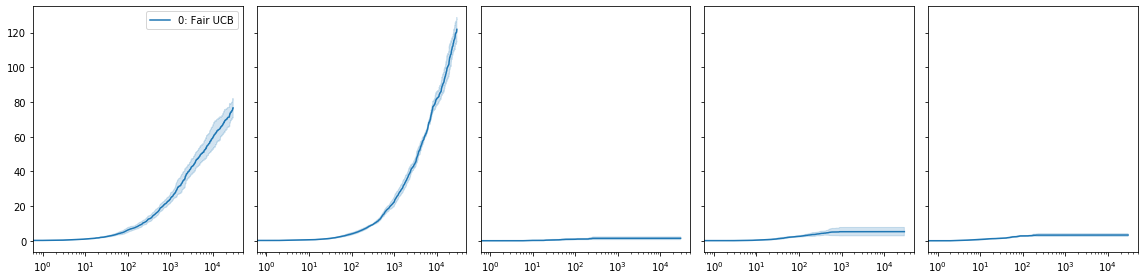

In [11]:
T = 30000

#eps = 1.
alg_list = [#FairUCB(K, C, label='Fair kl-UCB', noise="bernoulli"),
            FairUCB(K, C, sig=1/2, label='Fair UCB', noise="gaussian"),
            #L1OFUL(K, C, label="L1OFUL", delta=1/T),
            #FairEpsGreedy(K, C, label=r'$\epsilon$-greedy, $\epsilon =$'+str(eps), epsilon=eps), 
            #FairEpsGreedy(K, C, label="FTL", epsilon=0),
           ]

N_tests = [5 for _ in band_list]

data_dict={
        'name':'Transition from logarithmic to bounded regret gaussian noise',
        'short_name':'logvbounded_FTL',
        'T':T,
        'N_tests':N_tests,
        'band_list':band_list,
        'alg_list':alg_list,
        'results':None,   
        'folder': '../figures/diversity/',
    }

#launch(data_dict, fair_reg=True, checkpoints=True)

skips = []
plot_and_save(data_dict,
                save_figure=False,
                skip_algs=skips,
                log_scale=True,
                show_vars=True,
                )


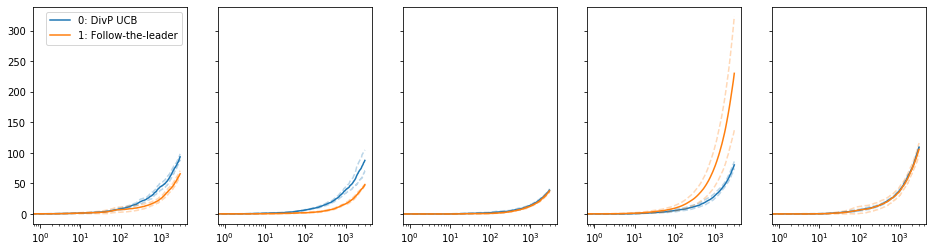

# General constraints

## Mode d'emploi : 

La cellule juste en dessous sert à générer un problème de bandit. Comme on génère les contraintes aléatoirement, il se peut qu'elles ne soient pas réalisables. Dans ce cas il faut relancer la cellule jusqu'à ce qu'elle affiche ''Optimization terminated successfully.''

K est la dimension du problème
n_cons le nombre de contraintes
C est un objet contrainte, qui implémente les fonctions de base, en particulier optimiser. Pour l'initialiser, on donne une liste de triplets $\big($l(ower), u(pper), s$\big)$ où s est un vecteur dans $\{0, 1\}^K$

In [ ]:
K = 5

mus = np.random.rand(K)
mus_list = [mus]

n_cons = 3
constraints_list = [(0.7*np.random.rand(), 1,np.array([1*(np.random.rand() > 1/2) for _ in range(K)])) for _ in range(n_cons)]
C = PolytopeConstraints(K, constraints_list)

band_list = [FairBand(K, mus, C, noise=noise)]

min_reward = C.argmax_dot(-mus)
max_reward = C.argmax_dot(mus)
print(max_reward)
delta_max =  max_reward.fun - (- min_reward.fun)
print("Un point qui vérifie les contraintes : ", C.feasible)
print("Ecart maximum pour ce problème : ", delta_max)

Ici on met la liste d'algorithmes que l'on souhaite tester

In [ ]:
T = 5000

alg_list = [FairUCB(K, C, label='FairUCB'),
            L1OFUL(K, C, label='OFUL', delta=1/T),
           ]

data_dict={
        'name':'General case',
        'short_name':'gen_case',
        'T':T,
        'Ntest':Ntest,
        'band_list':band_list,
        'alg_list':alg_list,
        'results':None,   
    }

launch(data_dict, fair_reg=True)

In [ ]:
print(data_dict['name'])
plot_and_save(data_dict, save_data=False, skip_algs=[1])

print('worst possible perf : ',str(T*delta_max))

In [18]:
a = [1,2,3,4]
b = [5,6]*2
c  = zip(a, b)
print([x for x in c])

[(1, 5), (2, 6), (3, 5), (4, 6)]


In [5]:
ls ../data_saves/continuous

cont_test.pkl


(<Figure size 1152x288 with 2 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x102954f4a8>,
       dtype=object))

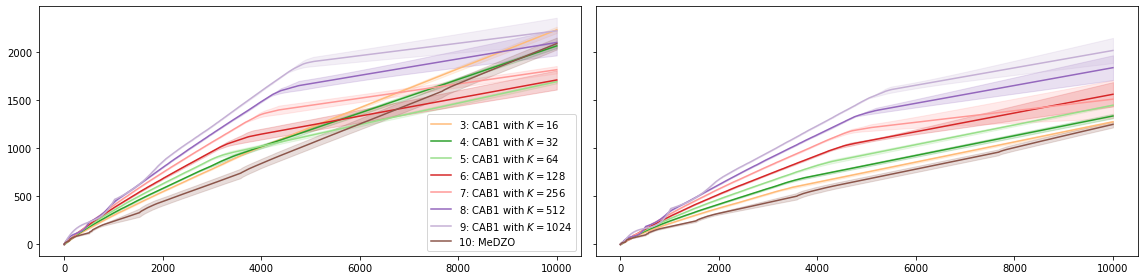

In [26]:
data_dict = load_data_dict('data_saves/continuous/cont_test.pkl')

skips= [0, 1, 2]

plot_and_save(data_dict,
              save_data=False,
              skip_algs=skips,
              log_scale=False)

